In [2]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

%matplotlib inline

In [3]:
if not '../../data/osha/osha_norm_naics.csv':
    with zipfile.ZipFile('../../data/osha/osha_norm_naics.zip','r') as zfile:
        zfile.extractall('../../data/osha')
osha = pd.read_csv('../../data/osha/osha_norm_naics.csv', dtype={'naics_code':str, 'sic_code':str},
                  na_values = ["", " ","NaN", "nan", "NA", "na", "Na"])
osha = osha[['date_sampled','inspection_number', 'establishment_name', 'preferred_name','naics_unified', 'sector_name', 'subsector_name',
             'industry_group_name', 'conc_mgm3']]  # keep only cols we need
osha['date_sampled'] = osha['date_sampled'].str.slice(0,4).astype(int)
osha = osha[~osha['sector_name'].isin(["Undefined/Multiple"])]
osha = osha.drop(osha[osha['conc_mgm3']>10000].index)
osha = osha.dropna(subset=['conc_mgm3', 'sector_name'])
#osha['sector_enc'] = osha['sector_name'].astype('category').cat.codes
#osha['subsector_enc'] = osha['subsector_name'].astype('category').cat.codes
#osha['industry_group_enc'] = osha['industry_group_name'].astype('category').cat.codes
osha['detected'] = np.where(osha['conc_mgm3'] > 0, 1, 0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (0,7,11,20,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
osha = osha.groupby(['inspection_number', 'establishment_name', 'preferred_name','naics_unified', 'sector_name',
                     'subsector_name', 'industry_group_name'], as_index=False).max(numeric_only=True)
osha.head(6)

inspection_number                    establishment_name preferred_name  \
0             29067                      GARMAT USA, INC.     Iron oxide   
1             29206                     Polar Corporation     Iron oxide   
2             29251                         Jobsite, Inc.     Iron oxide   
3             29479           TIC, The Industrial Company     Iron oxide   
4             63156  Nomad Global Communication Solutions     Iron oxide   
5             63259       PRECISION PLATING COMPANY, INC.     Iron oxide   

  naics_unified     sector_name  \
0        332322   Manufacturing   
1        811310  Other Services   
2        333517   Manufacturing   
3        236210    Construction   
4        334290   Manufacturing   
5        332813   Manufacturing   

                                  subsector_name  \
0         Fabricated Metal Product Manufacturing   
1                         Repair and Maintenance   
2                        Machinery Manufacturing   
3                      Construction of Buildings   
4  Computer and Electronic Product Manufacturing   
5         Fabricated Metal Product Manufacturing   

                                 industry_group_name  date_sampled  conc_mgm3  \
0  Architectural and Structural Metals Manufacturing          2011   1.959734   
1  Commercial and Industrial Machinery and Equipm...          2011  12.966245   
2               Metalworking Machinery Manufacturing          2011   0.519814   
3               Nonresidential Building Construction          2011   0.080790   
4             Communications Equipment Manufacturing          2011   3.093908   
5  Coating, Engraving, Heat Treating, and Allied ...          2011   0.000000   

   detected  
0         1  
1         1  
2         1  
3         1  
4         1  
5         0

In [92]:
len(osha)

233975

### Opera abiotic properties ONLY

In [6]:
opera = pd.read_csv('../../data/osha/chemical_metadata/opera2_physical.csv')
opera

PREFERRED_NAME     MoleculeID  LogP_pred  \
0                 1,1,1,2-Tetrafluoroethane  DTXSID1021324   0.827040   
1     1,1,1-Trichloro-2,2,2-trifluoroethane  DTXSID5027148   2.577394   
2    1,2-Difluoro-1,1,2,2-tetrachloroethane  DTXSID5026091   3.042323   
3                 1,1,2,2-Tetrachloroethane  DTXSID7021318   2.350099   
4     1,1,2-Trichloro-1,2,2-trifluoroethane  DTXSID6021377   2.966338   
..                                      ...            ...        ...   
728           4-Vinyl-1-cyclohexene dioxide  DTXSID0020604   0.670876   
729                    1,1-Dichloroethylene  DTXSID8021438   2.146029   
730                                  Oxamyl  DTXSID6021086  -0.537842   
731                                Warfarin  DTXSID5023742   2.688832   
732                             Mexacarbate  DTXSID7020893   2.485493   

        MP_pred     BP_pred  LogVP_pred  LogWS_pred  LogHL_pred    RT_pred  \
0   -102.840618  -22.605931    3.539329   -2.918477   -1.308825   1.077754   
1    -15.002823   48.806711    2.765054   -2.226180   -0.825878  11.526084   
2     24.586119   91.183236    1.878533   -3.075882   -0.782740  12.076823   
3    -39.864348  147.582052    0.862776   -1.754303   -3.300416  10.683509   
4    -44.225351   50.560073    2.682974   -2.994329   -1.081953   8.322817   
..          ...         ...         ...         ...         ...        ...   
728   75.401822  221.813643   -1.583812   -0.246298   -4.695892   6.542498   
729  -92.054831   41.134842    2.521820   -1.435674   -2.074198   0.000000   
730  100.495968  306.162430   -3.848174   -0.203799   -9.882354   2.713181   
731  162.602197  398.372135   -7.143559   -4.253120   -8.942250  16.801856   
732   89.080421  284.370981   -5.051546   -3.216383   -8.400635   7.863191   

     LogKOA_pred  LogD55_pred  LogD74_pred  LogOH_pred  LogKoc_pred  
0       0.036410     0.827040     0.827040  -14.241688     1.602622  
1       2.294088     2.577394     2.577394  -15.276176     1.861776  
2       3.710297     3.042323     3.042323  -14.523127     1.994880  
3       3.464204     2.350099     2.350099  -12.884900     1.894347  
4       2.818690     2.966338     2.966338  -15.292594     1.861775  
..           ...          ...          ...         ...          ...  
728     4.306213     0.670876     0.670876  -10.711082     1.762055  
729     2.597997     2.146029     2.146029  -10.958900     1.780304  
730     9.225506    -0.540338    -0.537873  -11.234750     1.099346  
731    10.660081     2.688832     2.688832  -10.475345     2.965329  
732     9.448105     2.484881     2.439394  -10.839304     2.380848  

[733 rows x 14 columns]

In [9]:
from sklearn.preprocessing import scale

opera = opera.drop(columns=['MoleculeID'])
#chem_data[chem_data.columns[8:]] = chem_data[chem_data.columns[8:]].apply(pd.to_numeric,errors='coerce')
opera.columns = [x.lower() for x in opera.columns]
opera_cols =  opera.columns[1:]
opera_s = opera.copy()
opera_s[opera_cols] =  scale(opera_s[opera_cols])  # center and scale opera predictors

In [12]:
#opera_s = opera_s.drop(columns=['octanol_air_partition_coeff_logkoa_opera_pred','melting_point_degc_opera_pred']) # drop highly correlated predictors
opera_cols = opera_s.columns.tolist()
opera_cols.remove('preferred_name')

chem_osha = osha.merge(opera_s, left_on='preferred_name', right_on='preferred_name')
chem_osha = chem_osha.dropna(subset=opera_cols)  # drop rows missing opera predictions
osha_enc = chem_osha.dropna(subset=['subsector_name'])
osha_enc = osha_enc.drop(osha_enc[osha_enc['subsector_name']=='Undefined/Multiple'].index)
osha_enc['sector_enc'] = osha_enc['sector_name'].astype('category').cat.codes  # re-factor
osha_enc['subsector_enc'] = osha_enc ['subsector_name'].astype('category').cat.codes  # re-factor
len(osha_enc.sector_name.value_counts()), len(osha_enc.subsector_name.value_counts())

(20, 91)

In [96]:
#from sklearn.preprocessing import PolynomialFeatures

#poly = PolynomialFeatures(interaction_only=True, include_bias=False)
#opera_s_ints = poly.fit_transform(osha_enc[opera_cols])
#opera_cols_ints = poly.get_feature_names()[10:]
#opera_interactions = pd.DataFrame(opera_s_ints[:,10:], columns=opera_cols_ints, index=osha_enc.index)
#osha_enc = osha_enc.join(opera_interactions)

In [15]:
sector_index = osha_enc.groupby(['sector_name']).all().reset_index().reset_index()[['index', 'sector_name']]
sector_subsector_index = osha_enc.groupby(['sector_name', 'subsector_name']).all().reset_index().reset_index()[['index', 'sector_name', 'subsector_name']]
sector_subsector_indexes_df = pd.merge(sector_index, sector_subsector_index, how='inner', on='sector_name', suffixes=('_s', '_ss'))
indexed_osha = pd.merge(osha_enc, sector_subsector_indexes_df, how = 'inner', on=['sector_name', 'subsector_name']).reset_index()

sector_indexes = sector_index['index'].values
sector_count = len(sector_indexes)
sector_subsector_indexes = sector_subsector_indexes_df['index_ss'].values
sector_subsector_count = len(sector_subsector_indexes)

#from sklearn.model_selection import train_test_split
#indexed_osha, indexed_osha_test = train_test_split(indexed_osha, test_size=0.1, random_state=5757)  # training/test dataset split completely random

indexed_osha_test = indexed_osha[indexed_osha['date_sampled'].isin(['1990','1995','2005' '2015'])]  # training/test dataset split by year
indexed_osha = indexed_osha[~(indexed_osha['date_sampled'].isin(['1990','1995','2005' '2015']))]

In [17]:
preds = indexed_osha[opera_cols]
npreds = len(opera_cols)

from theano import tensor as tt
from theano import shared

detected_shared = shared(indexed_osha.detected.values)
preds_shared = shared(preds.as_matrix())
index_s_shared = shared(indexed_osha.index_s.values)
index_ss_shared = shared(indexed_osha.index_ss.values)


with pm.Model() as osha_logistic_physical:
    
    global_mu = pm.StudentT('global_mu', nu=5, mu=0, sigma=10)
    global_lam = pm.HalfCauchy('global_lam',beta=25)
    
    sector_int_mu = pm.StudentT("sector_int_mu",nu = 5, mu = global_mu, sigma=global_lam, shape=sector_count)

    sigma_subsector_int = pm.HalfCauchy('sigma_subsector_int',beta=25)
    
    subsector_int = pm.StudentT("subsector_int", 1, mu=sector_int_mu[sector_subsector_indexes_df['index_s']],
                          sigma=sigma_subsector_int, shape=sector_subsector_count)
    beta = pm.StudentT('beta',nu=5,mu=0,sigma=2.5, shape=(npreds))  # recommended by stan wiki, Gelman et al 2008
    μ = subsector_int[index_ss_shared] + tt.dot(preds_shared,beta)
    
    θ = pm.Deterministic('θ',pm.math.sigmoid(μ))
    
    like = pm.Bernoulli(
        'likelihood',
        p = θ,
        observed=detected_shared
    )

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [19]:
with osha_logistic_physical:
    fr_advi = pm.FullRankADVI()
tracker = pm.callbacks.Tracker(
    mean=fr_advi.approx.mean.eval,  # callable that returns mean
    std=fr_advi.approx.std.eval  # callable that returns std
)
fit = fr_advi.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(), tracker])
#fit = fr_advi.fit(50000, callbacks=[pm.callbacks.CheckParametersConvergence(), tracker])


  0%|          | 0/100000 [00:00<?, ?it/s]/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple seq

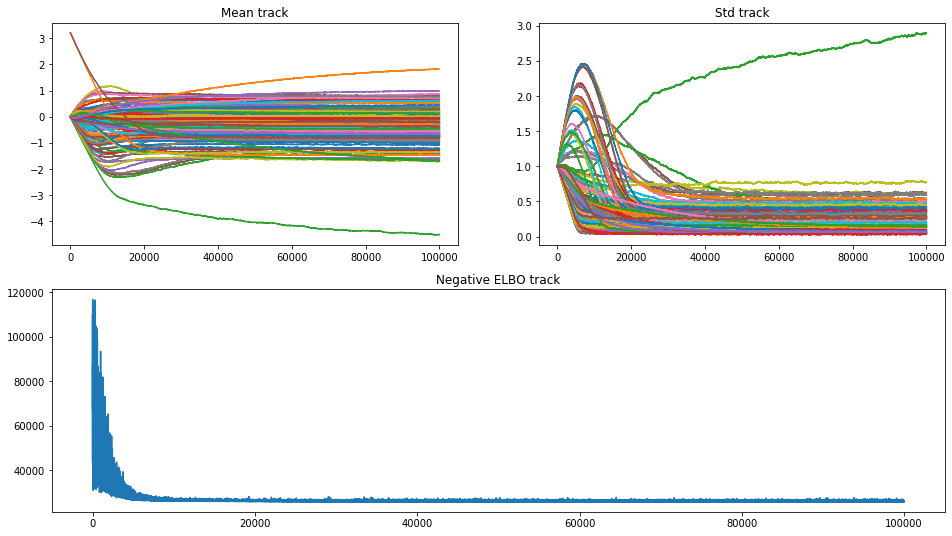

In [20]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(fit.hist)
hist_ax.set_title('Negative ELBO track');

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


<Figure size 432x1152 with 0 Axes>

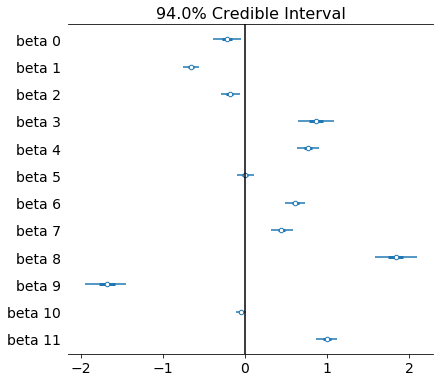

In [21]:
from pymc3 import forestplot
plt.figure(figsize=(6,16))
#forestplot(mean_field.sample(1000), kind='ridgeplot', colors='white', var_names=['beta']);
forestplot(fit.sample(1000), var_names=['beta']);
plt.axvline(x=0, color='black')

In [23]:
for i, var in enumerate(opera_cols):
    print('beta {}: {}'.format(i,var))

beta 0: logp_pred
beta 1: mp_pred
beta 2: bp_pred
beta 3: logvp_pred
beta 4: logws_pred
beta 5: loghl_pred
beta 6: rt_pred
beta 7: logkoa_pred
beta 8: logd55_pred
beta 9: logd74_pred
beta 10: logoh_pred
beta 11: logkoc_pred


## Posterior predictive checks

#### Average across 500 sets of probablistic predictions

In [26]:
ppc = pm.sample_posterior_predictive(fit.sample(1000), samples= 500, model=osha_logistic_physical)
avg_predictions = np.where(ppc['likelihood'].mean(axis=0) >= 0.5, 1, 0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
100%|██████████| 500/500 [00:07<00:00, 65.51it/s]


#### Classification accuracy metrics

In [27]:
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score
accuracy = accuracy_score(avg_predictions, indexed_osha['detected'])
auc = roc_auc_score(avg_predictions, indexed_osha['detected'])
print('Training classification accuracy: {:.2f}'.format(accuracy))
print('Training ROC area under the curve: {:.2f}'.format(auc))

Training classification accuracy: 0.70
Training ROC area under the curve: 0.68


In [28]:
null_predictions = np.where(np.random.uniform(size=len(indexed_osha['detected'])) >
                                        indexed_osha['detected'].mean(),1,0)
null_accuracy = accuracy_score(null_predictions,indexed_osha['detected'])
null_auc = roc_auc_score(null_predictions, indexed_osha['detected'])
print('Null model training classification accuracy: {:.2f}'.format(null_accuracy))
print('Null model training ROC area under the curve: {:.2f}'.format(null_auc))

Null model training classification accuracy: 0.47
Null model training ROC area under the curve: 0.50


#### Actual vs predicted subsector detection frequency

In [29]:
subsector_probs = indexed_osha[['detected', 'index_ss']].copy()
subsector_probs['prob_predicted'] = avg_predictions
subsector_probs = subsector_probs.groupby('index_ss').mean()
subsector_counts = indexed_osha['index_ss'].value_counts()
#subsector_probs = subsector_probs[subsector_counts > 10] # drop subsectors with very few data points
r = np.corrcoef(subsector_probs['detected'], subsector_probs['prob_predicted'])[0,1]

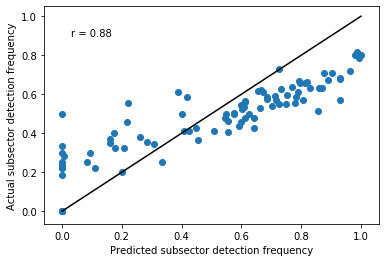

In [30]:
plt.scatter( subsector_probs['prob_predicted'], subsector_probs['detected'])
plt.plot([0, 1], [0, 1], color='black')
plt.xlabel('Predicted subsector detection frequency')
plt.ylabel('Actual subsector detection frequency')
plt.text(0.03, 0.9, 'r = {:.2f}'.format(r))
plt.show()

#### Test set accuracy

In [31]:
preds_test = indexed_osha_test[opera_cols]
detected_shared.set_value(indexed_osha_test.detected.values)
preds_shared.set_value(preds_test.as_matrix())
index_s_shared.set_value(indexed_osha_test.index_s.values)
index_ss_shared.set_value(indexed_osha_test.index_ss.values)

ppc_test = pm.sample_posterior_predictive(fit.sample(1000), samples= 500, model=osha_logistic_physical)
avg_predictions_test = np.where(ppc_test['likelihood'].mean(axis=0) >= 0.5, 1, 0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
100%|██████████| 500/500 [00:05<00:00, 89.73it/s]


In [32]:
accuracy = accuracy_score(avg_predictions_test, indexed_osha_test['detected'])
null_predictions_test = np.where(np.random.uniform(size=len(indexed_osha_test['detected'])) >
                                        indexed_osha_test['detected'].mean(),1,0)
null_accuracy = accuracy_score(null_predictions_test,indexed_osha_test['detected'])
auc = roc_auc_score(avg_predictions_test, indexed_osha_test['detected'])
null_auc = roc_auc_score(null_predictions_test, indexed_osha_test['detected'])
print('Test classification accuracy: {:.2f}'.format(accuracy))
print('Null model test classification accuracy: {:.2f}'.format(null_accuracy))
print('Test ROC area under the curve: {:.2f}'.format(auc))
print('Null model test ROC area under the curve: {:.2f}'.format(null_auc))


Test classification accuracy: 0.70
Null model test classification accuracy: 0.46
Test ROC area under the curve: 0.67
Null model test ROC area under the curve: 0.50


/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


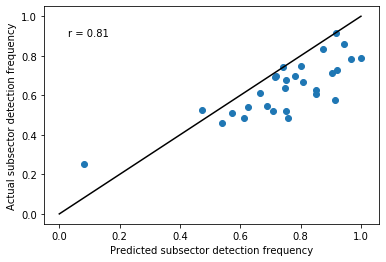

In [33]:
subsector_probs_test = indexed_osha_test[['detected', 'index_ss']].copy()
subsector_probs_test['prob_predicted'] = avg_predictions_test
subsector_probs_test = subsector_probs_test.groupby('index_ss').mean()
subsector_counts_test = indexed_osha_test['index_ss'].value_counts()
subsector_probs_test = subsector_probs_test[subsector_counts_test > 10] # drop subsectors with very few data points
r = np.corrcoef(subsector_probs_test['detected'], subsector_probs_test['prob_predicted'])[0,1]

plt.scatter(subsector_probs_test['prob_predicted'], subsector_probs_test['detected'])
plt.plot([0, 1], [0, 1], color='black')
plt.xlabel('Predicted subsector detection frequency')
plt.ylabel('Actual subsector detection frequency')
plt.text(0.03, 0.9, 'r = {:.2f}'.format(r))
plt.show()

## Opera abiotic properties + biological properties

In [44]:
opera = pd.read_csv('../../data/osha/chemical_metadata/opera2_physical_biological.csv')
opera

PREFERRED_NAME     MoleculeID  LogP_pred  \
0                 1,1,1,2-Tetrafluoroethane  DTXSID1021324   0.827040   
1     1,1,1-Trichloro-2,2,2-trifluoroethane  DTXSID5027148   2.577394   
2    1,2-Difluoro-1,1,2,2-tetrachloroethane  DTXSID5026091   3.042323   
3                 1,1,2,2-Tetrachloroethane  DTXSID7021318   2.350099   
4     1,1,2-Trichloro-1,2,2-trifluoroethane  DTXSID6021377   2.966338   
..                                      ...            ...        ...   
728           4-Vinyl-1-cyclohexene dioxide  DTXSID0020604   0.670876   
729                    1,1-Dichloroethylene  DTXSID8021438   2.146029   
730                                  Oxamyl  DTXSID6021086  -0.537842   
731                                Warfarin  DTXSID5023742   2.688832   
732                             Mexacarbate  DTXSID7020893   2.485493   

        MP_pred     BP_pred  LogVP_pred  LogWS_pred  LogHL_pred    RT_pred  \
0   -102.840618  -22.605931    3.539329   -2.918477   -1.308825   1.077754   
1    -15.002823   48.806711    2.765054   -2.226180   -0.825878  11.526084   
2     24.586119   91.183236    1.878533   -3.075882   -0.782740  12.076823   
3    -39.864348  147.582052    0.862776   -1.754303   -3.300416  10.683509   
4    -44.225351   50.560073    2.682974   -2.994329   -1.081953   8.322817   
..          ...         ...         ...         ...         ...        ...   
728   75.401822  221.813643   -1.583812   -0.246298   -4.695892   6.542498   
729  -92.054831   41.134842    2.521820   -1.435674   -2.074198   0.000000   
730  100.495968  306.162430   -3.848174   -0.203799   -9.882354   2.713181   
731  162.602197  398.372135   -7.143559   -4.253120   -8.942250  16.801856   
732   89.080421  284.370981   -5.051546   -3.216383   -8.400635   7.863191   

     LogKOA_pred  LogD55_pred  LogD74_pred  LogOH_pred  LogKoc_pred  \
0       0.036410     0.827040     0.827040  -14.241688     1.602622   
1       2.294088     2.577394     2.577394  -15.276176     1.861776   
2       3.710297     3.042323     3.042323  -14.523127     1.994880   
3       3.464204     2.350099     2.350099  -12.884900     1.894347   
4       2.818690     2.966338     2.966338  -15.292594     1.861775   
..           ...          ...          ...         ...          ...   
728     4.306213     0.670876     0.670876  -10.711082     1.762055   
729     2.597997     2.146029     2.146029  -10.958900     1.780304   
730     9.225506    -0.540338    -0.537873  -11.234750     1.099346   
731    10.660081     2.688832     2.688832  -10.475345     2.965329   
732     9.448105     2.484881     2.439394  -10.839304     2.380848   

     LogBCF_pred  BioDeg_LogHalfLife_pred  ReadyBiodeg_pred  LogKM_pred  \
0       1.140721                 0.879337               1.0   -1.018823   
1       1.219245                 0.879336               0.0    1.100178   
2       1.651911                 1.147999               0.0    0.680101   
3       1.071377                 1.162160               0.0   -0.678153   
4       1.624601                 0.670627               0.0    1.087855   
..           ...                      ...               ...         ...   
728     0.544835                 0.563320               0.0   -0.845404   
729     1.036647                 0.901319               0.0   -0.756178   
730     0.330434                 0.668337               0.0   -1.028647   
731     1.250233                 0.525285               0.0   -0.388300   
732     1.404878                 0.711142               0.0   -0.457404   

     FUB_pred  Clint_pred  
0    0.938953    1.126115  
1    0.682392    1.053753  
2    0.505783    1.127796  
3    0.101371    1.049232  
4    0.872214    1.053753  
..        ...         ...  
728  0.752539   -4.002069  
729  0.342199    1.094112  
730  0.807243   -6.611441  
731  0.014048   -5.274753  
732  0.660895    0.778462  

[733 rows x 20 columns]

In [45]:
from sklearn.preprocessing import scale

opera = opera.drop(columns=['MoleculeID'])
#chem_data[chem_data.columns[8:]] = chem_data[chem_data.columns[8:]].apply(pd.to_numeric,errors='coerce')
opera.columns = [x.lower() for x in opera.columns]
opera_cols =  opera.columns[1:]
opera_s = opera.copy()
center_scale_cols = opera_cols.tolist().copy()
center_scale_cols.remove('readybiodeg_pred')
opera_s[center_scale_cols] =  scale(opera_s[center_scale_cols])  # center and scale opera predictors

In [46]:
#opera_s = opera_s.drop(columns=['octanol_air_partition_coeff_logkoa_opera_pred','melting_point_degc_opera_pred']) # drop highly correlated predictors
opera_cols = opera_s.columns.tolist()
opera_cols.remove('preferred_name')

chem_osha = osha.merge(opera_s, left_on='preferred_name', right_on='preferred_name')
chem_osha = chem_osha.dropna(subset=opera_cols)  # drop rows missing opera predictions
osha_enc = chem_osha.dropna(subset=['subsector_name'])
osha_enc = osha_enc.drop(osha_enc[osha_enc['subsector_name']=='Undefined/Multiple'].index)
osha_enc['sector_enc'] = osha_enc['sector_name'].astype('category').cat.codes  # re-factor
osha_enc['subsector_enc'] = osha_enc ['subsector_name'].astype('category').cat.codes  # re-factor
len(osha_enc.sector_name.value_counts()), len(osha_enc.subsector_name.value_counts())

(20, 91)

In [96]:
#from sklearn.preprocessing import PolynomialFeatures

#poly = PolynomialFeatures(interaction_only=True, include_bias=False)
#opera_s_ints = poly.fit_transform(osha_enc[opera_cols])
#opera_cols_ints = poly.get_feature_names()[10:]
#opera_interactions = pd.DataFrame(opera_s_ints[:,10:], columns=opera_cols_ints, index=osha_enc.index)
#osha_enc = osha_enc.join(opera_interactions)

In [48]:
sector_index = osha_enc.groupby(['sector_name']).all().reset_index().reset_index()[['index', 'sector_name']]
sector_subsector_index = osha_enc.groupby(['sector_name', 'subsector_name']).all().reset_index().reset_index()[['index', 'sector_name', 'subsector_name']]
sector_subsector_indexes_df = pd.merge(sector_index, sector_subsector_index, how='inner', on='sector_name', suffixes=('_s', '_ss'))
indexed_osha = pd.merge(osha_enc, sector_subsector_indexes_df, how = 'inner', on=['sector_name', 'subsector_name']).reset_index()

sector_indexes = sector_index['index'].values
sector_count = len(sector_indexes)
sector_subsector_indexes = sector_subsector_indexes_df['index_ss'].values
sector_subsector_count = len(sector_subsector_indexes)

#from sklearn.model_selection import train_test_split
#indexed_osha, indexed_osha_test = train_test_split(indexed_osha, test_size=0.1, random_state=5757)  # training/test dataset split completely random

indexed_osha_test = indexed_osha[indexed_osha['date_sampled'].isin(['1990','1995','2005' '2015'])]  # training/test dataset split by year
indexed_osha = indexed_osha[~(indexed_osha['date_sampled'].isin(['1990','1995','2005' '2015']))]

In [50]:
preds = indexed_osha[opera_cols]
npreds = len(opera_cols)

from theano import tensor as tt
from theano import shared

detected_shared = shared(indexed_osha.detected.values)
preds_shared = shared(preds.as_matrix())
index_s_shared = shared(indexed_osha.index_s.values)
index_ss_shared = shared(indexed_osha.index_ss.values)


with pm.Model() as osha_logistic_physical_biological:
    
    global_mu = pm.StudentT('global_mu', nu=5, mu=0, sigma=10)
    global_lam = pm.HalfCauchy('global_lam',beta=25)
    
    sector_int_mu = pm.StudentT("sector_int_mu",nu = 5, mu = global_mu, sigma=global_lam, shape=sector_count)

    sigma_subsector_int = pm.HalfCauchy('sigma_subsector_int',beta=25)
    
    subsector_int = pm.StudentT("subsector_int", 1, mu=sector_int_mu[sector_subsector_indexes_df['index_s']],
                          sigma=sigma_subsector_int, shape=sector_subsector_count)
    beta = pm.StudentT('beta',nu=5,mu=0,sigma=2.5, shape=(npreds))  # recommended by stan wiki, Gelman et al 2008
    μ = subsector_int[index_ss_shared] + tt.dot(preds_shared,beta)
    
    θ = pm.Deterministic('θ',pm.math.sigmoid(μ))
    
    like = pm.Bernoulli(
        'likelihood',
        p = θ,
        observed=detected_shared
    )

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [51]:
with osha_logistic_physical_biological:
    fr_advi = pm.FullRankADVI()
tracker = pm.callbacks.Tracker(
    mean=fr_advi.approx.mean.eval,  # callable that returns mean
    std=fr_advi.approx.std.eval  # callable that returns std
)
fit = fr_advi.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(), tracker])
#fit = fr_advi.fit(50000, callbacks=[pm.callbacks.CheckParametersConvergence(), tracker])


  0%|          | 0/100000 [00:00<?, ?it/s]/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple seq

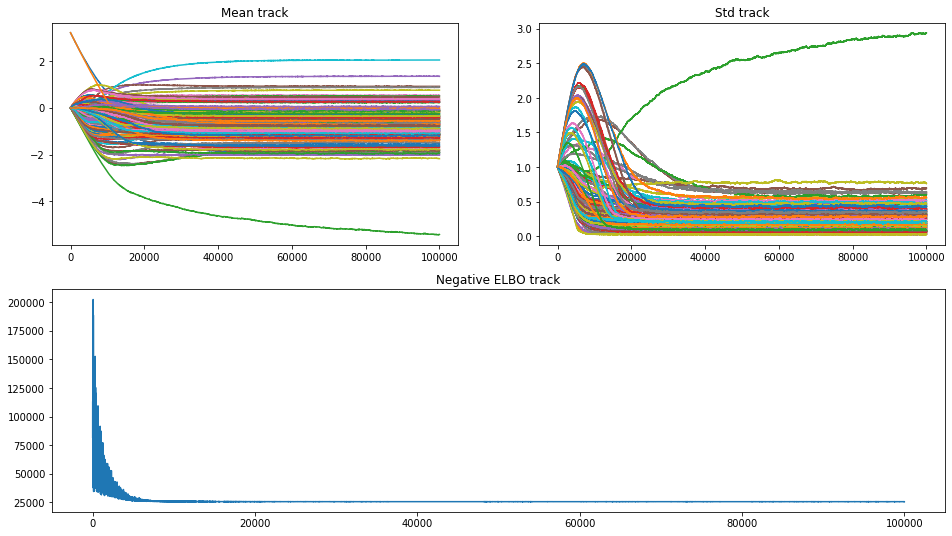

In [52]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(fit.hist)
hist_ax.set_title('Negative ELBO track');

<Figure size 432x1152 with 0 Axes>

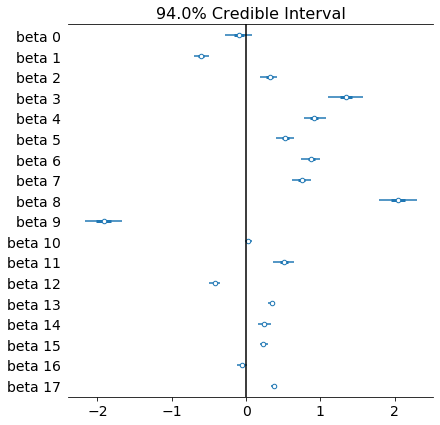

In [53]:
from pymc3 import forestplot
plt.figure(figsize=(6,16))
#forestplot(mean_field.sample(1000), kind='ridgeplot', colors='white', var_names=['beta']);
forestplot(fit.sample(1000), var_names=['beta']);
plt.axvline(x=0, color='black')

In [54]:
for i, var in enumerate(opera_cols):
    print('beta {}: {}'.format(i,var))

beta 0: logp_pred
beta 1: mp_pred
beta 2: bp_pred
beta 3: logvp_pred
beta 4: logws_pred
beta 5: loghl_pred
beta 6: rt_pred
beta 7: logkoa_pred
beta 8: logd55_pred
beta 9: logd74_pred
beta 10: logoh_pred
beta 11: logkoc_pred
beta 12: logbcf_pred
beta 13: biodeg_loghalflife_pred
beta 14: readybiodeg_pred
beta 15: logkm_pred
beta 16: fub_pred
beta 17: clint_pred


## Posterior predictive checks

#### Average across 500 sets of probablistic predictions

In [55]:
ppc = pm.sample_posterior_predictive(fit.sample(1000), samples= 500, model=osha_logistic_physical_biological)
avg_predictions = np.where(ppc['likelihood'].mean(axis=0) >= 0.5, 1, 0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
100%|██████████| 500/500 [00:07<00:00, 69.44it/s]


#### Classification accuracy metrics

In [56]:
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score
accuracy = accuracy_score(avg_predictions, indexed_osha['detected'])
auc = roc_auc_score(avg_predictions, indexed_osha['detected'])
print('Training classification accuracy: {:.2f}'.format(accuracy))
print('Training ROC area under the curve: {:.2f}'.format(auc))

Training classification accuracy: 0.70
Training ROC area under the curve: 0.69


In [57]:
null_predictions = np.where(np.random.uniform(size=len(indexed_osha['detected'])) >
                                        indexed_osha['detected'].mean(),1,0)
null_accuracy = accuracy_score(null_predictions,indexed_osha['detected'])
null_auc = roc_auc_score(null_predictions, indexed_osha['detected'])
print('Null model training classification accuracy: {:.2f}'.format(null_accuracy))
print('Null model training ROC area under the curve: {:.2f}'.format(null_auc))

Null model training classification accuracy: 0.48
Null model training ROC area under the curve: 0.50


#### Actual vs predicted subsector detection frequency

In [58]:
subsector_probs = indexed_osha[['detected', 'index_ss']].copy()
subsector_probs['prob_predicted'] = avg_predictions
subsector_probs = subsector_probs.groupby('index_ss').mean()
subsector_counts = indexed_osha['index_ss'].value_counts()
#subsector_probs = subsector_probs[subsector_counts > 10] # drop subsectors with very few data points
r = np.corrcoef(subsector_probs['detected'], subsector_probs['prob_predicted'])[0,1]

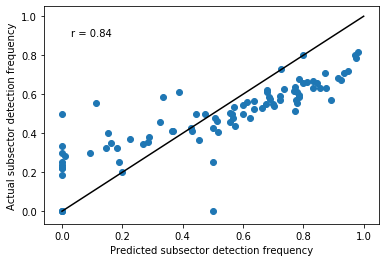

In [59]:
plt.scatter( subsector_probs['prob_predicted'], subsector_probs['detected'])
plt.plot([0, 1], [0, 1], color='black')
plt.xlabel('Predicted subsector detection frequency')
plt.ylabel('Actual subsector detection frequency')
plt.text(0.03, 0.9, 'r = {:.2f}'.format(r))
plt.show()

#### Test set accuracy

In [60]:
preds_test = indexed_osha_test[opera_cols]
detected_shared.set_value(indexed_osha_test.detected.values)
preds_shared.set_value(preds_test.as_matrix())
index_s_shared.set_value(indexed_osha_test.index_s.values)
index_ss_shared.set_value(indexed_osha_test.index_ss.values)

ppc_test = pm.sample_posterior_predictive(fit.sample(1000), samples= 500, model=osha_logistic_physical_biological)
avg_predictions_test = np.where(ppc_test['likelihood'].mean(axis=0) >= 0.5, 1, 0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
100%|██████████| 500/500 [00:05<00:00, 83.87it/s]


In [61]:
accuracy = accuracy_score(avg_predictions_test, indexed_osha_test['detected'])
null_predictions_test = np.where(np.random.uniform(size=len(indexed_osha_test['detected'])) >
                                        indexed_osha_test['detected'].mean(),1,0)
null_accuracy = accuracy_score(null_predictions_test,indexed_osha_test['detected'])
auc = roc_auc_score(avg_predictions_test, indexed_osha_test['detected'])
null_auc = roc_auc_score(null_predictions_test, indexed_osha_test['detected'])
print('Test classification accuracy: {:.2f}'.format(accuracy))
print('Null model test classification accuracy: {:.2f}'.format(null_accuracy))
print('Test ROC area under the curve: {:.2f}'.format(auc))
print('Null model test ROC area under the curve: {:.2f}'.format(null_auc))


Test classification accuracy: 0.70
Null model test classification accuracy: 0.46
Test ROC area under the curve: 0.68
Null model test ROC area under the curve: 0.49


/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


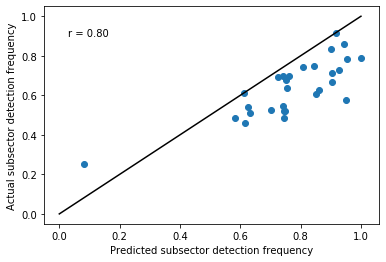

In [62]:
subsector_probs_test = indexed_osha_test[['detected', 'index_ss']].copy()
subsector_probs_test['prob_predicted'] = avg_predictions_test
subsector_probs_test = subsector_probs_test.groupby('index_ss').mean()
subsector_counts_test = indexed_osha_test['index_ss'].value_counts()
subsector_probs_test = subsector_probs_test[subsector_counts_test > 10] # drop subsectors with very few data points
r = np.corrcoef(subsector_probs_test['detected'], subsector_probs_test['prob_predicted'])[0,1]

plt.scatter(subsector_probs_test['prob_predicted'], subsector_probs_test['detected'])
plt.plot([0, 1], [0, 1], color='black')
plt.xlabel('Predicted subsector detection frequency')
plt.ylabel('Actual subsector detection frequency')
plt.text(0.03, 0.9, 'r = {:.2f}'.format(r))
plt.show()

### Opera abiotic + structural

In [90]:
opera = pd.read_csv('../../data/osha/chemical_metadata/opera2_physical_structural.csv')
opera

PREFERRED_NAME     MoleculeID  LogP_pred  \
0                 1,1,1,2-Tetrafluoroethane  DTXSID1021324   0.827040   
1     1,1,1-Trichloro-2,2,2-trifluoroethane  DTXSID5027148   2.577394   
2    1,2-Difluoro-1,1,2,2-tetrachloroethane  DTXSID5026091   3.042323   
3                 1,1,2,2-Tetrachloroethane  DTXSID7021318   2.350099   
4     1,1,2-Trichloro-1,2,2-trifluoroethane  DTXSID6021377   2.966338   
..                                      ...            ...        ...   
728           4-Vinyl-1-cyclohexene dioxide  DTXSID0020604   0.670876   
729                    1,1-Dichloroethylene  DTXSID8021438   2.146029   
730                                  Oxamyl  DTXSID6021086  -0.537842   
731                                Warfarin  DTXSID5023742   2.688832   
732                             Mexacarbate  DTXSID7020893   2.485493   

        MP_pred     BP_pred  LogVP_pred  LogWS_pred  LogHL_pred    RT_pred  \
0   -102.840618  -22.605931    3.539329   -2.918477   -1.308825   1.077754   
1    -15.002823   48.806711    2.765054   -2.226180   -0.825878  11.526084   
2     24.586119   91.183236    1.878533   -3.075882   -0.782740  12.076823   
3    -39.864348  147.582052    0.862776   -1.754303   -3.300416  10.683509   
4    -44.225351   50.560073    2.682974   -2.994329   -1.081953   8.322817   
..          ...         ...         ...         ...         ...        ...   
728   75.401822  221.813643   -1.583812   -0.246298   -4.695892   6.542498   
729  -92.054831   41.134842    2.521820   -1.435674   -2.074198   0.000000   
730  100.495968  306.162430   -3.848174   -0.203799   -9.882354   2.713181   
731  162.602197  398.372135   -7.143559   -4.253120   -8.942250  16.801856   
732   89.080421  284.370981   -5.051546   -3.216383   -8.400635   7.863191   

     LogKOA_pred  ...  nbHeteroRing  Sp3Sp2HybRatio  nbRotBd  nbHBdAcc  \
0       0.036410  ...             0        1.000000        1         0   
1       2.294088  ...             0        1.000000        1         0   
2       3.710297  ...             0        1.000000        1         0   
3       3.464204  ...             0        1.000000        1         0   
4       2.818690  ...             0        1.000000        1         0   
..           ...  ...           ...             ...      ...       ...   
728     4.306213  ...             2        1.000000        1         2   
729     2.597997  ...             0        0.000000        0         0   
730     9.225506  ...             0        0.571429        6         4   
731    10.660081  ...             1        0.210526        4         3   
732     9.448105  ...             0        0.416667        4         3   

     ndHBdDon  nbLipinskiFailures  TopoPolSurfAir  MolarRefract  \
0           0                   0            0.00       12.0193   
1           0                   0            0.00       27.3736   
2           0                   0            0.00       32.2084   
3           0                   0            0.00       30.7638   
4           0                   0            0.00       27.3736   
..        ...                 ...             ...           ...   
728         0                   0           25.06       32.7621   
729         0                   0            0.00       20.4606   
730         1                   0           96.30       53.0132   
731         0                   0           60.44       34.1518   
732         1                   0           41.57       39.7851   

     CombDipolPolariz   MolWeight  
0              -0.020  102.009263  
1               0.089  185.901768  
2               0.363  201.872217  
3               0.577  165.891061  
4               0.239  185.901768  
..                ...         ...  
728             0.791  140.083730  
729             0.457   95.953355  
730             1.644  219.067762  
731             2.985  308.104859  
732             0.984  222.136828  

[733 rows x 31 columns]

In [91]:
from sklearn.preprocessing import scale

opera = opera.drop(columns=['MoleculeID'])
#chem_data[chem_data.columns[8:]] = chem_data[chem_data.columns[8:]].apply(pd.to_numeric,errors='coerce')
opera.columns = [x.lower() for x in opera.columns]
opera_cols =  opera.columns[1:]
opera_s = opera.copy()
center_scale_cols =  [x for x in opera_cols.tolist() if not x.startswith('nb') and not x.startswith('nd')]
opera_s[center_scale_cols] =  scale(opera_s[center_scale_cols])  # center and scale opera predictors

In [92]:
#opera_s = opera_s.drop(columns=['octanol_air_partition_coeff_logkoa_opera_pred','melting_point_degc_opera_pred']) # drop highly correlated predictors
opera_cols = opera_s.columns.tolist()
opera_cols.remove('preferred_name')

chem_osha = osha.merge(opera_s, left_on='preferred_name', right_on='preferred_name')
chem_osha = chem_osha.dropna(subset=opera_cols)  # drop rows missing opera predictions
osha_enc = chem_osha.dropna(subset=['subsector_name'])
osha_enc = osha_enc.drop(osha_enc[osha_enc['subsector_name']=='Undefined/Multiple'].index)
osha_enc['sector_enc'] = osha_enc['sector_name'].astype('category').cat.codes  # re-factor
osha_enc['subsector_enc'] = osha_enc ['subsector_name'].astype('category').cat.codes  # re-factor
len(osha_enc.sector_name.value_counts()), len(osha_enc.subsector_name.value_counts())

(20, 91)

In [96]:
#from sklearn.preprocessing import PolynomialFeatures

#poly = PolynomialFeatures(interaction_only=True, include_bias=False)
#opera_s_ints = poly.fit_transform(osha_enc[opera_cols])
#opera_cols_ints = poly.get_feature_names()[10:]
#opera_interactions = pd.DataFrame(opera_s_ints[:,10:], columns=opera_cols_ints, index=osha_enc.index)
#osha_enc = osha_enc.join(opera_interactions)

In [94]:
sector_index = osha_enc.groupby(['sector_name']).all().reset_index().reset_index()[['index', 'sector_name']]
sector_subsector_index = osha_enc.groupby(['sector_name', 'subsector_name']).all().reset_index().reset_index()[['index', 'sector_name', 'subsector_name']]
sector_subsector_indexes_df = pd.merge(sector_index, sector_subsector_index, how='inner', on='sector_name', suffixes=('_s', '_ss'))
indexed_osha = pd.merge(osha_enc, sector_subsector_indexes_df, how = 'inner', on=['sector_name', 'subsector_name']).reset_index()

sector_indexes = sector_index['index'].values
sector_count = len(sector_indexes)
sector_subsector_indexes = sector_subsector_indexes_df['index_ss'].values
sector_subsector_count = len(sector_subsector_indexes)

#from sklearn.model_selection import train_test_split
#indexed_osha, indexed_osha_test = train_test_split(indexed_osha, test_size=0.1, random_state=5757)  # training/test dataset split completely random

indexed_osha_test = indexed_osha[indexed_osha['date_sampled'].isin(['1990','1995','2005' '2015'])]  # training/test dataset split by year
indexed_osha = indexed_osha[~(indexed_osha['date_sampled'].isin(['1990','1995','2005' '2015']))]

In [96]:
preds = indexed_osha[opera_cols]
npreds = len(opera_cols)

from theano import tensor as tt
from theano import shared

detected_shared = shared(indexed_osha.detected.values)
preds_shared = shared(preds.as_matrix())
index_s_shared = shared(indexed_osha.index_s.values)
index_ss_shared = shared(indexed_osha.index_ss.values)


with pm.Model() as osha_logistic_physical_structural:
    
    global_mu = pm.StudentT('global_mu', nu=5, mu=0, sigma=10)
    global_lam = pm.HalfCauchy('global_lam',beta=25)
    
    sector_int_mu = pm.StudentT("sector_int_mu",nu = 5, mu = global_mu, sigma=global_lam, shape=sector_count)

    sigma_subsector_int = pm.HalfCauchy('sigma_subsector_int',beta=25)
    
    subsector_int = pm.StudentT("subsector_int", 1, mu=sector_int_mu[sector_subsector_indexes_df['index_s']],
                          sigma=sigma_subsector_int, shape=sector_subsector_count)
    beta = pm.StudentT('beta',nu=5,mu=0,sigma=2.5, shape=(npreds))  # recommended by stan wiki, Gelman et al 2008
    μ = subsector_int[index_ss_shared] + tt.dot(preds_shared,beta)
    
    θ = pm.Deterministic('θ',pm.math.sigmoid(μ))
    
    like = pm.Bernoulli(
        'likelihood',
        p = θ,
        observed=detected_shared
    )

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [97]:
with osha_logistic_all:
    fr_advi = pm.FullRankADVI()
tracker = pm.callbacks.Tracker(
    mean=fr_advi.approx.mean.eval,  # callable that returns mean
    std=fr_advi.approx.std.eval  # callable that returns std
)
fit = fr_advi.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(), tracker])
#fit = fr_advi.fit(50000, callbacks=[pm.callbacks.CheckParametersConvergence(), tracker])


  0%|          | 0/100000 [00:00<?, ?it/s]/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Average Loss = 29,583: 100%|██████████| 100000/100000 [13:17<00:00, 125.39it/s]
Finished [100%]: Average Loss = 29,554


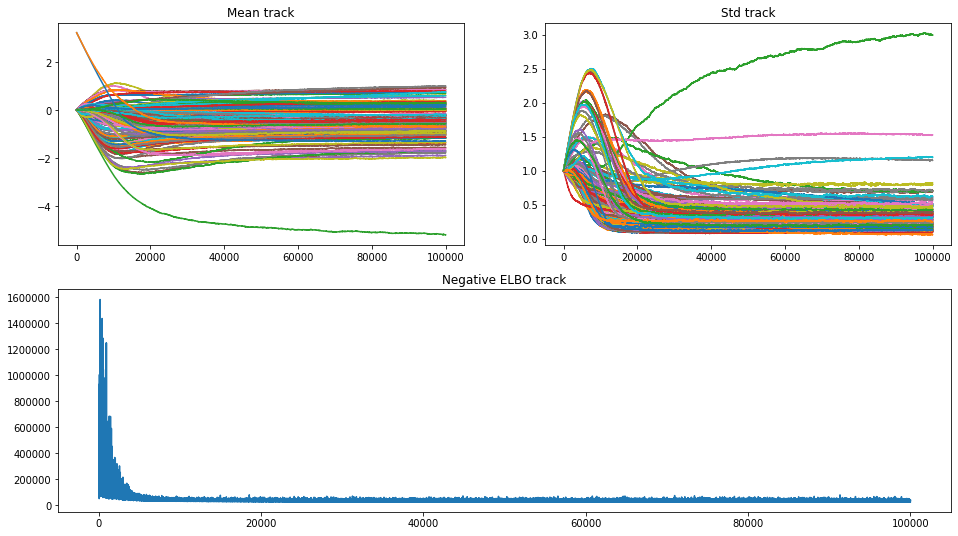

In [98]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(fit.hist)
hist_ax.set_title('Negative ELBO track');

<Figure size 432x1152 with 0 Axes>

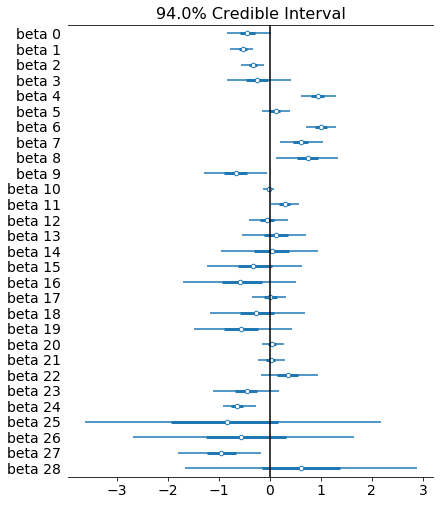

In [99]:
from pymc3 import forestplot
plt.figure(figsize=(6,16))
#forestplot(mean_field.sample(1000), kind='ridgeplot', colors='white', var_names=['beta']);
forestplot(fit.sample(1000), var_names=['beta']);
plt.axvline(x=0, color='black')

In [100]:
for i, var in enumerate(opera_cols):
    print('beta {}: {}'.format(i,var))

beta 0: logp_pred
beta 1: mp_pred
beta 2: bp_pred
beta 3: logvp_pred
beta 4: logws_pred
beta 5: loghl_pred
beta 6: rt_pred
beta 7: logkoa_pred
beta 8: logd55_pred
beta 9: logd74_pred
beta 10: logoh_pred
beta 11: logkoc_pred
beta 12: nbatoms
beta 13: nbheavyatoms
beta 14: nbc
beta 15: nbo
beta 16: nbn
beta 17: nbaromatom
beta 18: nbring
beta 19: nbheteroring
beta 20: sp3sp2hybratio
beta 21: nbrotbd
beta 22: nbhbdacc
beta 23: ndhbddon
beta 24: nblipinskifailures
beta 25: topopolsurfair
beta 26: molarrefract
beta 27: combdipolpolariz
beta 28: molweight


## Posterior predictive checks

#### Average across 500 sets of probablistic predictions

In [101]:
ppc = pm.sample_posterior_predictive(fit.sample(1000), samples= 500, model=osha_logistic_physical_structural)
avg_predictions = np.where(ppc['likelihood'].mean(axis=0) >= 0.5, 1, 0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
100%|██████████| 500/500 [00:07<00:00, 67.33it/s]


#### Classification accuracy metrics

In [102]:
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score
accuracy = accuracy_score(avg_predictions, indexed_osha['detected'])
auc = roc_auc_score(avg_predictions, indexed_osha['detected'])
print('Training classification accuracy: {:.2f}'.format(accuracy))
print('Training ROC area under the curve: {:.2f}'.format(auc))

Training classification accuracy: 0.70
Training ROC area under the curve: 0.70


In [103]:
null_predictions = np.where(np.random.uniform(size=len(indexed_osha['detected'])) >
                                        indexed_osha['detected'].mean(),1,0)
null_accuracy = accuracy_score(null_predictions,indexed_osha['detected'])
null_auc = roc_auc_score(null_predictions, indexed_osha['detected'])
print('Null model training classification accuracy: {:.2f}'.format(null_accuracy))
print('Null model training ROC area under the curve: {:.2f}'.format(null_auc))

Null model training classification accuracy: 0.47
Null model training ROC area under the curve: 0.50


#### Actual vs predicted subsector detection frequency

In [104]:
subsector_probs = indexed_osha[['detected', 'index_ss']].copy()
subsector_probs['prob_predicted'] = avg_predictions
subsector_probs = subsector_probs.groupby('index_ss').mean()
subsector_counts = indexed_osha['index_ss'].value_counts()
#subsector_probs = subsector_probs[subsector_counts > 10] # drop subsectors with very few data points
r = np.corrcoef(subsector_probs['detected'], subsector_probs['prob_predicted'])[0,1]

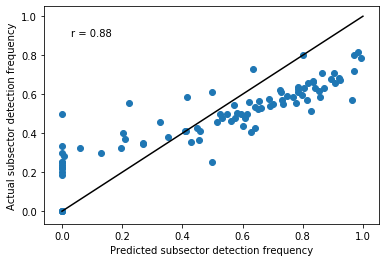

In [105]:
plt.scatter( subsector_probs['prob_predicted'], subsector_probs['detected'])
plt.plot([0, 1], [0, 1], color='black')
plt.xlabel('Predicted subsector detection frequency')
plt.ylabel('Actual subsector detection frequency')
plt.text(0.03, 0.9, 'r = {:.2f}'.format(r))
plt.show()

#### Test set accuracy

In [106]:
preds_test = indexed_osha_test[opera_cols]
detected_shared.set_value(indexed_osha_test.detected.values)
preds_shared.set_value(preds_test.as_matrix())
index_s_shared.set_value(indexed_osha_test.index_s.values)
index_ss_shared.set_value(indexed_osha_test.index_ss.values)

ppc_test = pm.sample_posterior_predictive(fit.sample(1000), samples= 500, model=osha_logistic_physical_structural)
avg_predictions_test = np.where(ppc_test['likelihood'].mean(axis=0) >= 0.5, 1, 0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
100%|██████████| 500/500 [00:06<00:00, 78.28it/s]


In [107]:
accuracy = accuracy_score(avg_predictions_test, indexed_osha_test['detected'])
null_predictions_test = np.where(np.random.uniform(size=len(indexed_osha_test['detected'])) >
                                        indexed_osha_test['detected'].mean(),1,0)
null_accuracy = accuracy_score(null_predictions_test,indexed_osha_test['detected'])
auc = roc_auc_score(avg_predictions_test, indexed_osha_test['detected'])
null_auc = roc_auc_score(null_predictions_test, indexed_osha_test['detected'])
print('Test classification accuracy: {:.2f}'.format(accuracy))
print('Null model test classification accuracy: {:.2f}'.format(null_accuracy))
print('Test ROC area under the curve: {:.2f}'.format(auc))
print('Null model test ROC area under the curve: {:.2f}'.format(null_auc))


Test classification accuracy: 0.70
Null model test classification accuracy: 0.46
Test ROC area under the curve: 0.69
Null model test ROC area under the curve: 0.50


/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


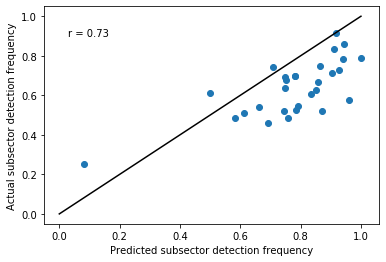

In [108]:
subsector_probs_test = indexed_osha_test[['detected', 'index_ss']].copy()
subsector_probs_test['prob_predicted'] = avg_predictions_test
subsector_probs_test = subsector_probs_test.groupby('index_ss').mean()
subsector_counts_test = indexed_osha_test['index_ss'].value_counts()
subsector_probs_test = subsector_probs_test[subsector_counts_test > 10] # drop subsectors with very few data points
r = np.corrcoef(subsector_probs_test['detected'], subsector_probs_test['prob_predicted'])[0,1]

plt.scatter(subsector_probs_test['prob_predicted'], subsector_probs_test['detected'])
plt.plot([0, 1], [0, 1], color='black')
plt.xlabel('Predicted subsector detection frequency')
plt.ylabel('Actual subsector detection frequency')
plt.text(0.03, 0.9, 'r = {:.2f}'.format(r))
plt.show()

### Opera abiotic + biotic + structural

In [64]:
opera = pd.read_csv('../../data/osha/chemical_metadata/opera2_all.csv')
opera

PREFERRED_NAME     MoleculeID  LogP_pred  \
0                 1,1,1,2-Tetrafluoroethane  DTXSID1021324   0.827040   
1     1,1,1-Trichloro-2,2,2-trifluoroethane  DTXSID5027148   2.577394   
2    1,2-Difluoro-1,1,2,2-tetrachloroethane  DTXSID5026091   3.042323   
3                 1,1,2,2-Tetrachloroethane  DTXSID7021318   2.350099   
4     1,1,2-Trichloro-1,2,2-trifluoroethane  DTXSID6021377   2.966338   
..                                      ...            ...        ...   
728           4-Vinyl-1-cyclohexene dioxide  DTXSID0020604   0.670876   
729                    1,1-Dichloroethylene  DTXSID8021438   2.146029   
730                                  Oxamyl  DTXSID6021086  -0.537842   
731                                Warfarin  DTXSID5023742   2.688832   
732                             Mexacarbate  DTXSID7020893   2.485493   

        MP_pred     BP_pred  LogVP_pred  LogWS_pred  LogHL_pred    RT_pred  \
0   -102.840618  -22.605931    3.539329   -2.918477   -1.308825   1.077754   
1    -15.002823   48.806711    2.765054   -2.226180   -0.825878  11.526084   
2     24.586119   91.183236    1.878533   -3.075882   -0.782740  12.076823   
3    -39.864348  147.582052    0.862776   -1.754303   -3.300416  10.683509   
4    -44.225351   50.560073    2.682974   -2.994329   -1.081953   8.322817   
..          ...         ...         ...         ...         ...        ...   
728   75.401822  221.813643   -1.583812   -0.246298   -4.695892   6.542498   
729  -92.054831   41.134842    2.521820   -1.435674   -2.074198   0.000000   
730  100.495968  306.162430   -3.848174   -0.203799   -9.882354   2.713181   
731  162.602197  398.372135   -7.143559   -4.253120   -8.942250  16.801856   
732   89.080421  284.370981   -5.051546   -3.216383   -8.400635   7.863191   

     LogKOA_pred  ...  TopoPolSurfAir  MolarRefract  CombDipolPolariz  \
0       0.036410  ...            0.00       12.0193            -0.020   
1       2.294088  ...            0.00       27.3736             0.089   
2       3.710297  ...            0.00       32.2084             0.363   
3       3.464204  ...            0.00       30.7638             0.577   
4       2.818690  ...            0.00       27.3736             0.239   
..           ...  ...             ...           ...               ...   
728     4.306213  ...           25.06       32.7621             0.791   
729     2.597997  ...            0.00       20.4606             0.457   
730     9.225506  ...           96.30       53.0132             1.644   
731    10.660081  ...           60.44       34.1518             2.985   
732     9.448105  ...           41.57       39.7851             0.984   

      MolWeight  LogBCF_pred  BioDeg_LogHalfLife_pred  ReadyBiodeg_pred  \
0    102.009263     1.140721                 0.879337               1.0   
1    185.901768     1.219245                 0.879336               0.0   
2    201.872217     1.651911                 1.147999               0.0   
3    165.891061     1.071377                 1.162160               0.0   
4    185.901768     1.624601                 0.670627               0.0   
..          ...          ...                      ...               ...   
728  140.083730     0.544835                 0.563320               0.0   
729   95.953355     1.036647                 0.901319               0.0   
730  219.067762     0.330434                 0.668337               0.0   
731  308.104859     1.250233                 0.525285               0.0   
732  222.136828     1.404878                 0.711142               0.0   

     LogKM_pred  FUB_pred  Clint_pred  
0     -1.018823  0.938953    1.126115  
1      1.100178  0.682392    1.053753  
2      0.680101  0.505783    1.127796  
3     -0.678153  0.101371    1.049232  
4      1.087855  0.872214    1.053753  
..          ...       ...         ...  
728   -0.845404  0.752539   -4.002069  
729   -0.756178  0.342199    1.094112  
730   -1.028647  0.807243   -6.611441  
731   -0.388300  0.014048   -5.274753

In [65]:
from sklearn.preprocessing import scale

opera = opera.drop(columns=['MoleculeID'])
#chem_data[chem_data.columns[8:]] = chem_data[chem_data.columns[8:]].apply(pd.to_numeric,errors='coerce')
opera.columns = [x.lower() for x in opera.columns]
opera_cols =  opera.columns[1:]
opera_s = opera.copy()
center_scale_cols =  [x for x in opera_cols.tolist() if not x.startswith('nb') and not x.startswith('nd')]
center_scale_cols.remove('readybiodeg_pred')
opera_s[center_scale_cols] =  scale(opera_s[center_scale_cols])  # center and scale opera predictors

In [67]:
#opera_s = opera_s.drop(columns=['octanol_air_partition_coeff_logkoa_opera_pred','melting_point_degc_opera_pred']) # drop highly correlated predictors
opera_cols = opera_s.columns.tolist()
opera_cols.remove('preferred_name')

chem_osha = osha.merge(opera_s, left_on='preferred_name', right_on='preferred_name')
chem_osha = chem_osha.dropna(subset=opera_cols)  # drop rows missing opera predictions
osha_enc = chem_osha.dropna(subset=['subsector_name'])
osha_enc = osha_enc.drop(osha_enc[osha_enc['subsector_name']=='Undefined/Multiple'].index)
osha_enc['sector_enc'] = osha_enc['sector_name'].astype('category').cat.codes  # re-factor
osha_enc['subsector_enc'] = osha_enc ['subsector_name'].astype('category').cat.codes  # re-factor
len(osha_enc.sector_name.value_counts()), len(osha_enc.subsector_name.value_counts())

(20, 91)

In [96]:
#from sklearn.preprocessing import PolynomialFeatures

#poly = PolynomialFeatures(interaction_only=True, include_bias=False)
#opera_s_ints = poly.fit_transform(osha_enc[opera_cols])
#opera_cols_ints = poly.get_feature_names()[10:]
#opera_interactions = pd.DataFrame(opera_s_ints[:,10:], columns=opera_cols_ints, index=osha_enc.index)
#osha_enc = osha_enc.join(opera_interactions)

In [69]:
sector_index = osha_enc.groupby(['sector_name']).all().reset_index().reset_index()[['index', 'sector_name']]
sector_subsector_index = osha_enc.groupby(['sector_name', 'subsector_name']).all().reset_index().reset_index()[['index', 'sector_name', 'subsector_name']]
sector_subsector_indexes_df = pd.merge(sector_index, sector_subsector_index, how='inner', on='sector_name', suffixes=('_s', '_ss'))
indexed_osha = pd.merge(osha_enc, sector_subsector_indexes_df, how = 'inner', on=['sector_name', 'subsector_name']).reset_index()

sector_indexes = sector_index['index'].values
sector_count = len(sector_indexes)
sector_subsector_indexes = sector_subsector_indexes_df['index_ss'].values
sector_subsector_count = len(sector_subsector_indexes)

#from sklearn.model_selection import train_test_split
#indexed_osha, indexed_osha_test = train_test_split(indexed_osha, test_size=0.1, random_state=5757)  # training/test dataset split completely random

indexed_osha_test = indexed_osha[indexed_osha['date_sampled'].isin(['1990','1995','2005' '2015'])]  # training/test dataset split by year
indexed_osha = indexed_osha[~(indexed_osha['date_sampled'].isin(['1990','1995','2005' '2015']))]

In [72]:
preds = indexed_osha[opera_cols]
npreds = len(opera_cols)

from theano import tensor as tt
from theano import shared

detected_shared = shared(indexed_osha.detected.values)
preds_shared = shared(preds.as_matrix())
index_s_shared = shared(indexed_osha.index_s.values)
index_ss_shared = shared(indexed_osha.index_ss.values)


with pm.Model() as osha_logistic_all:
    
    global_mu = pm.StudentT('global_mu', nu=5, mu=0, sigma=10)
    global_lam = pm.HalfCauchy('global_lam',beta=25)
    
    sector_int_mu = pm.StudentT("sector_int_mu",nu = 5, mu = global_mu, sigma=global_lam, shape=sector_count)

    sigma_subsector_int = pm.HalfCauchy('sigma_subsector_int',beta=25)
    
    subsector_int = pm.StudentT("subsector_int", 1, mu=sector_int_mu[sector_subsector_indexes_df['index_s']],
                          sigma=sigma_subsector_int, shape=sector_subsector_count)
    beta = pm.StudentT('beta',nu=5,mu=0,sigma=2.5, shape=(npreds))  # recommended by stan wiki, Gelman et al 2008
    μ = subsector_int[index_ss_shared] + tt.dot(preds_shared,beta)
    
    θ = pm.Deterministic('θ',pm.math.sigmoid(μ))
    
    like = pm.Bernoulli(
        'likelihood',
        p = θ,
        observed=detected_shared
    )

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [74]:
with osha_logistic_all:
    fr_advi = pm.FullRankADVI()
tracker = pm.callbacks.Tracker(
    mean=fr_advi.approx.mean.eval,  # callable that returns mean
    std=fr_advi.approx.std.eval  # callable that returns std
)
fit = fr_advi.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(), tracker])
#fit = fr_advi.fit(50000, callbacks=[pm.callbacks.CheckParametersConvergence(), tracker])


  0%|          | 0/100000 [00:00<?, ?it/s]/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Average Loss = 26,146: 100%|██████████| 100000/100000 [13:35<00:00, 122.62it/s]
Finished [100%]: Average Loss = 26,140


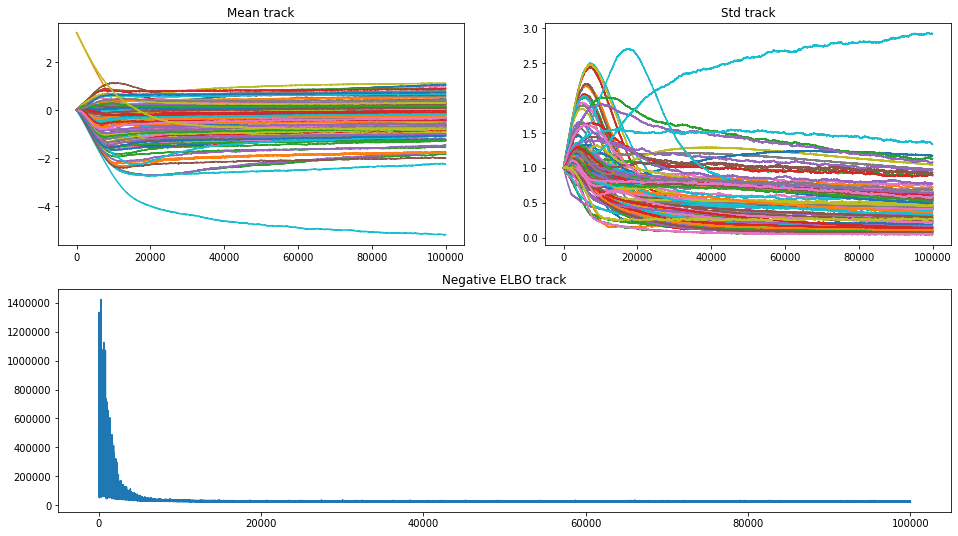

In [75]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(fit.hist)
hist_ax.set_title('Negative ELBO track');

<Figure size 432x1152 with 0 Axes>

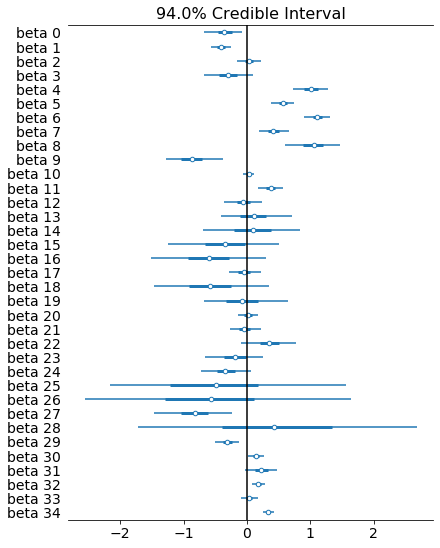

In [76]:
from pymc3 import forestplot
plt.figure(figsize=(6,16))
#forestplot(mean_field.sample(1000), kind='ridgeplot', colors='white', var_names=['beta']);
forestplot(fit.sample(1000), var_names=['beta']);
plt.axvline(x=0, color='black')

In [77]:
for i, var in enumerate(opera_cols):
    print('beta {}: {}'.format(i,var))

beta 0: logp_pred
beta 1: mp_pred
beta 2: bp_pred
beta 3: logvp_pred
beta 4: logws_pred
beta 5: loghl_pred
beta 6: rt_pred
beta 7: logkoa_pred
beta 8: logd55_pred
beta 9: logd74_pred
beta 10: logoh_pred
beta 11: logkoc_pred
beta 12: nbatoms
beta 13: nbheavyatoms
beta 14: nbc
beta 15: nbo
beta 16: nbn
beta 17: nbaromatom
beta 18: nbring
beta 19: nbheteroring
beta 20: sp3sp2hybratio
beta 21: nbrotbd
beta 22: nbhbdacc
beta 23: ndhbddon
beta 24: nblipinskifailures
beta 25: topopolsurfair
beta 26: molarrefract
beta 27: combdipolpolariz
beta 28: molweight
beta 29: logbcf_pred
beta 30: biodeg_loghalflife_pred
beta 31: readybiodeg_pred
beta 32: logkm_pred
beta 33: fub_pred
beta 34: clint_pred


## Posterior predictive checks

#### Average across 500 sets of probablistic predictions

In [78]:
ppc = pm.sample_posterior_predictive(fit.sample(1000), samples= 500, model=osha_logistic_all)
avg_predictions = np.where(ppc['likelihood'].mean(axis=0) >= 0.5, 1, 0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
100%|██████████| 500/500 [00:07<00:00, 70.94it/s]


#### Classification accuracy metrics

In [79]:
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score
accuracy = accuracy_score(avg_predictions, indexed_osha['detected'])
auc = roc_auc_score(avg_predictions, indexed_osha['detected'])
print('Training classification accuracy: {:.2f}'.format(accuracy))
print('Training ROC area under the curve: {:.2f}'.format(auc))

Training classification accuracy: 0.71
Training ROC area under the curve: 0.70


In [80]:
null_predictions = np.where(np.random.uniform(size=len(indexed_osha['detected'])) >
                                        indexed_osha['detected'].mean(),1,0)
null_accuracy = accuracy_score(null_predictions,indexed_osha['detected'])
null_auc = roc_auc_score(null_predictions, indexed_osha['detected'])
print('Null model training classification accuracy: {:.2f}'.format(null_accuracy))
print('Null model training ROC area under the curve: {:.2f}'.format(null_auc))

Null model training classification accuracy: 0.47
Null model training ROC area under the curve: 0.50


#### Actual vs predicted subsector detection frequency

In [81]:
subsector_probs = indexed_osha[['detected', 'index_ss']].copy()
subsector_probs['prob_predicted'] = avg_predictions
subsector_probs = subsector_probs.groupby('index_ss').mean()
subsector_counts = indexed_osha['index_ss'].value_counts()
#subsector_probs = subsector_probs[subsector_counts > 10] # drop subsectors with very few data points
r = np.corrcoef(subsector_probs['detected'], subsector_probs['prob_predicted'])[0,1]

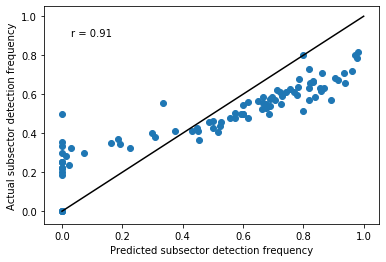

In [82]:
plt.scatter( subsector_probs['prob_predicted'], subsector_probs['detected'])
plt.plot([0, 1], [0, 1], color='black')
plt.xlabel('Predicted subsector detection frequency')
plt.ylabel('Actual subsector detection frequency')
plt.text(0.03, 0.9, 'r = {:.2f}'.format(r))
plt.show()

#### Test set accuracy

In [83]:
preds_test = indexed_osha_test[opera_cols]
detected_shared.set_value(indexed_osha_test.detected.values)
preds_shared.set_value(preds_test.as_matrix())
index_s_shared.set_value(indexed_osha_test.index_s.values)
index_ss_shared.set_value(indexed_osha_test.index_ss.values)

ppc_test = pm.sample_posterior_predictive(fit.sample(1000), samples= 500, model=osha_logistic_all)
avg_predictions_test = np.where(ppc_test['likelihood'].mean(axis=0) >= 0.5, 1, 0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
100%|██████████| 500/500 [00:05<00:00, 92.11it/s]


In [84]:
accuracy = accuracy_score(avg_predictions_test, indexed_osha_test['detected'])
null_predictions_test = np.where(np.random.uniform(size=len(indexed_osha_test['detected'])) >
                                        indexed_osha_test['detected'].mean(),1,0)
null_accuracy = accuracy_score(null_predictions_test,indexed_osha_test['detected'])
auc = roc_auc_score(avg_predictions_test, indexed_osha_test['detected'])
null_auc = roc_auc_score(null_predictions_test, indexed_osha_test['detected'])
print('Test classification accuracy: {:.2f}'.format(accuracy))
print('Null model test classification accuracy: {:.2f}'.format(null_accuracy))
print('Test ROC area under the curve: {:.2f}'.format(auc))
print('Null model test ROC area under the curve: {:.2f}'.format(null_auc))


Test classification accuracy: 0.70
Null model test classification accuracy: 0.47
Test ROC area under the curve: 0.68
Null model test ROC area under the curve: 0.51


/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


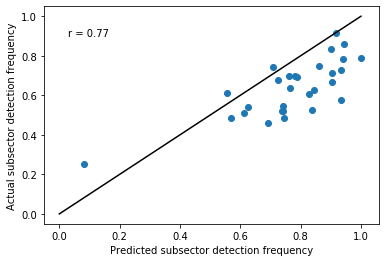

In [85]:
subsector_probs_test = indexed_osha_test[['detected', 'index_ss']].copy()
subsector_probs_test['prob_predicted'] = avg_predictions_test
subsector_probs_test = subsector_probs_test.groupby('index_ss').mean()
subsector_counts_test = indexed_osha_test['index_ss'].value_counts()
subsector_probs_test = subsector_probs_test[subsector_counts_test > 10] # drop subsectors with very few data points
r = np.corrcoef(subsector_probs_test['detected'], subsector_probs_test['prob_predicted'])[0,1]

plt.scatter(subsector_probs_test['prob_predicted'], subsector_probs_test['detected'])
plt.plot([0, 1], [0, 1], color='black')
plt.xlabel('Predicted subsector detection frequency')
plt.ylabel('Actual subsector detection frequency')
plt.text(0.03, 0.9, 'r = {:.2f}'.format(r))
plt.show()